In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
df = pd.read_csv("./Root_Insurance_data.csv")

# Use Random Forest to get the Probabilities of Different Customers to Buy Policies

We're estimating the probabilities using only customers who click, so that this estimates the true probability of customers to buy a policy, independent of where our ad was ranked.

In [5]:
# create data frame of customers who clicked our ad
# we will estimate the probabilities for each customer to buy a policy conditioned on clicking the ad

xdf_click = pd.get_dummies(df["Currently Insured"].loc[df.click])[["Y","unknown"]]
xdf_click.columns = ["insured","unknown"]
xdf_click[["cars2","cars3"]] = pd.get_dummies(df["Number of Vehicles"].loc[df.click])[[2,3]]
xdf_click[["drivers2"]] = pd.get_dummies(df["Number of Drivers"].loc[df.click])[[1]]
xdf_click[["married"]] = pd.get_dummies(df["Marital Status"].loc[df.click])[["M"]]
xdf_click[["policies_sold"]] = df[["policies_sold"]].loc[df.click].copy()

In [6]:
xdf_click.head()

,insured,unknown,cars2,cars3,drivers2,married,policies_sold
12,1,0,1,0,1,0,1
14,0,1,1,0,0,0,1
16,0,1,0,0,0,1,1
28,0,1,0,0,0,1,1
32,0,1,1,0,0,1,0


In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
tree = RandomForestClassifier()

In [9]:
tree.fit(xdf_click.loc[:, xdf_click.columns!="policies_sold"],xdf_click.policies_sold)

RandomForestClassifier()

In [11]:
tree.predict_proba(xdf_click.loc[:, xdf_click.columns!="policies_sold"])

array([[0.72241266, 0.27758734],
       [0.61369375, 0.38630625],
       [0.44974436, 0.55025564],
       ...,
       [0.67303364, 0.32696636],
       [0.45939805, 0.54060195],
       [0.59668525, 0.40331475]])

In [43]:
tree.predict_proba([[0,0,0,0,0,0]])[0,1]

0.4073051071254356

In [12]:
# initialize np array for class probabilities
p = np.zeros(36)
# create list to remember the numbers
class_list = {}
idx = 0
for i in ["Y","unknown","N"]:
    for c in [1,2,3]:
        for d in [1,2]:
            for m in ["married","single"]:
                X = [[ (i=="Y"), (i=="unknown"), (c==2),(c==3),(d==2),(m=="married")]]
                # get probability for class idx
                p[idx] = tree.predict_proba(X)[0,1]
                class_list[idx] = (i,"cars"+str(c),"drivers"+str(d),m)
                idx+=1
                

In [13]:
p

array([0.32696636, 0.31772703, 0.31727874, 0.49582178, 0.37516413,
       0.19948193, 0.32109186, 0.27758734, 0.10924937, 0.4165706 ,
       0.19032896, 0.1970274 , 0.55025564, 0.42969227, 0.52714164,
       0.54060195, 0.27629182, 0.38630625, 0.48451734, 0.41218785,
       0.43645073, 0.37121727, 0.36639369, 0.38896504, 0.42197187,
       0.40331475, 0.55785321, 0.58326495, 0.43890383, 0.47195511,
       0.41129067, 0.31567381, 0.54413246, 0.22788909, 0.57190949,
       0.36676702])

# Get the Estimates of the Rate Parameters

In [15]:
# create column in dataFrame which associates each entry to a class 0 to 35
df["class"] = 0

lm = np.zeros(36)
idx=0
for i in ["Y","unknown","N"]:
    for c in [1,2,3]:
        for d in [1,2]:
            for m in ["M","S"]:
                # get the average rank for class idx
                r = df["rank"].loc[(df["Marital Status"]==m)&(df["Number of Drivers"]==d)\
                                 &(df["Number of Vehicles"]==c)&(df["Currently Insured"]==i)].mean()
                df.loc[(df["Marital Status"]==m)&(df["Number of Drivers"]==d)\
                                 &(df["Number of Vehicles"]==c)&(df["Currently Insured"]==i), "class"] = idx
                # there is one class (unknown insurance, single, 3 vehicles, 2 drivers); idx = 24
                # that has zero representatives, 
                # for this one we will use the global average bid
                # alternatively we could estimate it with logistic regression
                # for now we set it to the average rank=3.1841
                if np.isnan(r):
                    r = df["rank"].mean()
                lm[idx] = 10/np.log(4/(r-1))
                idx+=1
                r=0

# Get Coefficients for Click-Thru rate by Rank

In [19]:
click_rates_by_rank = df.groupby("rank").click.mean().to_numpy()

Code for gradient descent

In [ ]:
import scipy.special

In [34]:
# regularization parameter
alpha = 1

In [50]:

# find the expected click rate for each bid
# if change the CDF also update dRdb in dLdb(bids,batch)
def ExpectedClickRate(bids):
    arr = np.zeros(36)
    for i in range(36):
        s = 0 
        for j in range(4):
            s += scipy.special.binom(4,j)*click_rates_by_rank[j]*\
                ((np.exp(-bids[i]/lm[i]))**j)*((1 - np.exp(-bids[i]/lm[i]))**(4-j))
        arr[i]=s
    return arr

def ExpectedCost(bids,batch):
    clicks = ExpectedClickRate(bids)
    s = 0
    for a in batch:
        # add up bid for each customer times probability to click
        s+= bids[a]*clicks[a]
    return s

        
def ExpectedPoliciesSold(bids,batch):
    clicks = ExpectedClickRate(bids)
    s = 0
    for a in batch:
        # add up probability to click times probability to buy conditioned on click
        s+= p[a]*clicks[a]
    return s
    
# Loss here is log cost per customer acquired. Seek to minimize loss function
def Loss(bids,batch):
    policies = ExpectedPoliciesSold(bids,batch)
    return np.log( ExpectedCost(bids,batch)) - np.log(policies) + alpha*np.log((policies-399)/(policies-400))

# calculate the gradient of Loss function
# to change CDF need to chance dRdb
def dLdb(bids,batch):
    clicks = ExpectedClickRate(bids)
    cost = ExpectedCost(bids,batch)
    policies = ExpectedPoliciesSold(bids,batch)
    
    # compute gradient of ExpectedClickRate
    dRdb = np.zeros(36)
    # compute gradient of ExpectedCost
    dCdb = np.zeros(36)
    # compute gradient of ExpectedPoliciesSold
    dPdb = np.zeros(36)
    for i in range(36):
        s=0
        for j in range(4):
            s-=click_rates_by_rank[j]*scipy.special.binom(4,j)*\
                ((np.exp(-bids[i]/lm[i]))**j)*((1 - np.exp(-bids[i]/lm[i]))**(4-j))*j/lm[i]
            s+= click_rates_by_rank[j]*scipy.special.binom(4,j)*\
                ((np.exp(-bids[i]/lm[i]))**(j+1))*((1 - np.exp(-bids[i]/lm[i]))**(3-j))*(4-j)/lm[i]
        # set value of gradient Expected click rate
        dRdb[i] = s
        
        # set value of gradient expected cost
        dCdb[i] += clicks[i]
        dCdb[i] += b[i]*dRdb[i]
        
        # set values for gradient expected policies sold
        dPdb[i] = p[i]*dRdb[i]
    
    # now compute the gradience of Loss
    arr = np.zeros(36)
    for a in batch:
        arr[a] += dCdb[a]/cost - dPdb[a]/policies + alpha*dPdb[a]*( 1/(policies - 399) - 1/(policies-400))
    return arr

# Implement Gradient Descent

33186
Final bids =  [ 3.56257589  3.35884951  3.35425897  5.24338727  4.75797229  3.62246171
  4.18048348  3.92284033  2.43818947  5.17724648  3.56229414  3.47165277
  5.61536707  4.47473339  5.39200139  5.5257029   2.92871736  4.06460206
  5.00247218  4.32947461  4.61715296  3.92223566  3.8728467  10.
  4.50710387  4.30823597  5.89008835  6.15270323  5.77435852  5.72756259
  4.38297697  3.41778319  6.41802355  3.38583883  6.35701489  4.5984415 ]
Cost  4471.745572218199
Policies  419.19208247095514
Cost per policy  10.667533475010316


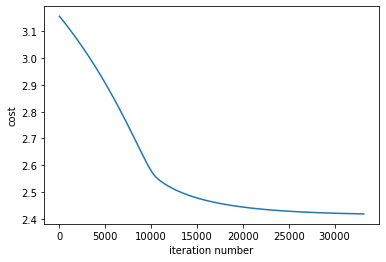

In [61]:
# Initialize all bids at $10
b=10*np.ones(36)

# Number of iterations to do grad descent
niterations=int(5*1e4)


# Learning rate
epsilon=.1

m=10000
# minimum possible bid
min_val = 0.01

samples = df["class"].to_numpy()
batch = samples #np.random.choice(samples, size=m, replace=True)

losses=np.zeros(niterations+1)
losses[0]=Loss(b, batch)
for i in range(niterations):
    # batch = np.random.choice(samples, size=m, replace=True)
    grad = dLdb(b, batch)
    if sum(np.abs(grad))<.01:
        print(i)
        break
    b = b-epsilon*grad
    # set any negative values to min_val
    b[b<min_val] = min_val
    losses[i+1]=Loss(b,batch)
    if ExpectedPoliciesSold(b,batch)<400:
        break

plt.figure()
plt.plot(losses[losses>0])
plt.ylabel("loss")
plt.xlabel("iteration number")
#plt.yscale("log")
print("Final bids = ",b)
print("Cost ", ExpectedCost(b,samples))
print("Policies ", ExpectedPoliciesSold(b,samples))
print("Cost per policy ", ExpectedCost(b,samples)/ExpectedPoliciesSold(b,samples))

# Variance Estimate of the Solution

Now that we have optimized the cost per policy sold subject to the constraint that we sell at least 400 policies per 10,000, on average, we want to estimate a confidence percentage that our bid strategy will actually acquire at least 400 customers out of 10,000. 

To do this we use bootstrapping to repeatedly produce samples of 10,000 customers from the emperical distribution and use this to estimate the standard deviation of policies per 10,000

In [62]:
niterations=10000
arr= np.zeros(niterations)
for i in range(niterations):
    batch = np.random.choice(samples, size=10000, replace=True)
    arr[i] = ExpectedPoliciesSold(b, batch)
m = np.mean(arr)
s = np.std(arr)
print("Mean: ", m)
print("St Dev: ",s)

Mean:  419.1754571347845
St Dev:  4.116781495421123


We conclude with high degree of confidence that the true number of customers will be greater than 400.

In [63]:
from scipy.stats import norm

norm.cdf(400, loc=m,scale=s)

1.5974438335353494e-06